# Intro
This notebook shows how we processed American Community Survey data, downloaded from IPUMS, into usable reference tables for our analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from pprint import pprint
pd.set_option("max_columns",0)

Data pulled from [IPUMS](https://usa.ipums.org/usa/index.shtml). Data pull is filtered on 2 things: 
1) Person lives in the Northeast Region (Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont, New Jersey, New York, Pennsylvania)  
2) Person works in New York State  
![ipums screenshot](images/ipums_data_pull.png)

### Read in data, clean up columns

In [2]:
### Read in reference tables. Puma names, TranWork reference table
puma_df = pd.read_csv("ipums_data/pumanames_us_2019_clean.csv",index_col=0)
### Tranwork allows 1-many matches to the HBD TranWork column
tranwork_df = pd.read_csv("ipums_data/ipums_tranwork_reference_updated.csv",index_col=0)

In [3]:
### Read in IPUMS data, join to puma + tranwork reference tables
### First, read in IPUMS data for all NE residents that work in NYS
### We will filter this down on only those that work in NYC
ipums_df_WorksNYS = pd.read_csv("ipums_data/ipums_data_all_NE.csv") 
ipums_df_WorksNYS = ipums_df_WorksNYS.merge(right=puma_df,on=["STATEFIP","PUMA"])
ipums_df_WorksNYS = ipums_df_WorksNYS.merge(right=tranwork_df,on=["TRANWORK"])
orig_len = len(ipums_df_WorksNYS)
### Filter down to just people who work in Manhattan (the lowest relevant granularity ACS has for P.O.W.)
### Has to be done at both state and PWPuma level - PWPUMA is state dependent
works_in_ny = ipums_df_WorksNYS['PWSTATE2']==36
works_in_manhattan = ipums_df_WorksNYS["PWPUMA00"]==3800

ipums_df_WorksNYS = ipums_df_WorksNYS[works_in_ny&works_in_manhattan]


pd.DataFrame([['Rows in Raw Data','Rows after filtering'],[orig_len,len(ipums_df_WorksNYS)]]).T

,0,1
0,Rows in Raw Data,289250
1,Rows after filtering,67328


In [4]:
### Second, read in IPUMS data for NY residents - we are going to filter those that 
###  live in Manhattan and work elsewhere

manhattan_pumanames = puma_df[puma_df['PUMA_NAME'].str.contains("NYC-Manh")]["PUMA_NAME"].values

ipums_df_NY_Res = pd.read_csv("ipums_data/ipums_ny_only.csv")
ipums_df_NY_Res = ipums_df_NY_Res.merge(right=puma_df,on=["STATEFIP","PUMA"])
ipums_df_NY_Res = ipums_df_NY_Res.merge(right=tranwork_df,on=["TRANWORK"])

orig_len = len(ipums_df_NY_Res)
### We want NYS residents who live in Manhattan, work, and don't work in Manhattan
works_in_ny = ipums_df_NY_Res['PWSTATE2']==36
works_in_manhattan = ipums_df_NY_Res["PWPUMA00"]==3800
lives_in_manhattan = ipums_df_NY_Res["PUMA_NAME"].isin(manhattan_pumanames)
works_at_all = ipums_df_NY_Res['PWSTATE2']>0

ipums_df_NY_Res = ipums_df_NY_Res[(~works_in_manhattan)&(lives_in_manhattan)&(works_at_all)]

pd.DataFrame([['Rows in Raw Data','Rows after filtering'],[orig_len,len(ipums_df_NY_Res)]]).T

,0,1
0,Rows in Raw Data,592340
1,Rows after filtering,2351


In [5]:
### Some quick checks

In [6]:
ipums_df_WorksNYS.groupby(by=["YEAR"]).agg({"PERWT":'sum'}) 
### This looks good - about 2.6MM commute into Manhattan (pre-COVID)

,PERWT
YEAR,
2017,2621994.0
2018,2622616.0
2019,2671634.0


In [7]:
ipums_df_NY_Res.groupby(by=["YEAR"]).agg({"PERWT":'sum'}) 
### This looks good
### About 122K Manhattan residents commuted outside of the borough for work (see source below)
# https://www1.nyc.gov/assets/planning/download/pdf/planning-level/housing-economy/nyc-ins-and-out-of-commuting.pdf

,PERWT
YEAR,
2017,145789.0
2018,137391.0
2019,122621.0


In [8]:
### Concatenate dataframes together - add commute_dir column for ease of filtering
ipums_df_WorksNYS['commute_dir'] = 'in'
ipums_df_NY_Res['commute_dir'] = 'out'

ipums_df = pd.concat([ipums_df_WorksNYS,ipums_df_NY_Res])
ipums_df.reset_index(inplace=True)
ipums_df.groupby(by=["YEAR",'commute_dir']).agg({"PERWT":'sum'}) 

### Looks good

PERWT
YEAR commute_dir           
2017 in           2621994.0
     out           145789.0
2018 in           2622616.0
     out           137391.0
2019 in           2671634.0
     out           122621.0

In [9]:
### Clean up some columns and convert to legible values

## Sex
ipums_df["SEX"] = ipums_df["SEX"].replace({1:"M",2:"F"})

## Health Conditions
health_cols = ['DIFFREM','DIFFPHYS','DIFFMOB','DIFFCARE','DIFFSENS','DIFFEYE','DIFFHEAR']
ipums_df[health_cols]=ipums_df[health_cols].replace({1:0,2:1})

## Home Ownership / Rental
ipums_df["OWNERSHP_LABEL"]=ipums_df["OWNERSHP"].replace({0:"N/A",1:"Rent",2:"Own"})

## Race
ipums_df["RACE_LABEL"]=ipums_df["RACE"].replace({1:"White",2:"BlackAA",3:"AmerIndianAlaskan"\
                                                    ,4:"Chinese",5:"Japanese",6:"OtherAsianPacIsl"\
                                                    ,7:"OtherRace",8:"TwoRaces",9:"ThreePlusRaces"})
## Education Level
ipums_df["EDUC_LABEL"]=ipums_df["EDUC"].replace({0:"N/A_NoSchool",1:"Grade0_4",2:"Grades5_8"\
                                                    ,3:"Grade9",4:"Grade10",5:"Grade11"\
                                                    ,6:"Grades12",7:"College_1Year",8:"College_2Year"\
                                                    ,9:"College_3Year",10:"College_4Year"\
                                                 ,11:"College_5PlusYears"})

## Daily Work Hours
## UHRSWORK reports the number of hours per week that the respondent usually worked,
ipums_df['HRS_WK_DAILY'] = ipums_df['UHRSWORK']/5


### Create Hourly Columns from Departs/Arrives times
ipums_df["DEPARTS_HOUR"] = ipums_df["DEPARTS"]//100
ipums_df["ARRIVES_HOUR"] = ipums_df["ARRIVES"]//100

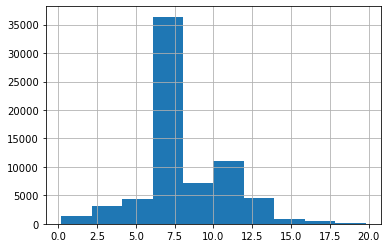

In [10]:
ipums_df['HRS_WK_DAILY'].hist(); #that looks about right

In [11]:
# ipums_df['TRANWORK_DESC'].value_counts()

In [12]:
# ipums_df['TRANWORK_HBDMATCH'].value_counts()

In [13]:
### Check out the data
print((ipums_df.shape))
ipums_df.head(5)

(69679, 60)


,index,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,REGION,STATEFIP,COUNTYFIP,DENSITY,CITY,PUMA,STRATA,GQ,OWNERSHP,OWNERSHPD,CINETHH,PERNUM,PERWT,SEX,AGE,RACE,RACED,HISPAN,HISPAND,EDUC,EDUCD,EMPSTAT,EMPSTATD,WKSWORK2,UHRSWORK,INCTOT,POVERTY,DIFFREM,DIFFPHYS,DIFFMOB,DIFFCARE,DIFFSENS,DIFFEYE,DIFFHEAR,PWSTATE2,PWCOUNTY,PWPUMA00,TRANWORK,CARPOOL,RIDERS,TRANTIME,DEPARTS,ARRIVES,PUMA_NAME,TRANWORK_DESC,TRANWORK_HBDMATCH,commute_dir,OWNERSHP_LABEL,RACE_LABEL,EDUC_LABEL,HRS_WK_DAILY,DEPARTS_HOUR,ARRIVES_HOUR
0,11,2017,201701.0,247218.0,2.017001e+12,42.0,2.017002e+12,11.0,9,5,415.4,0.0,500,50009.0,1.0,1,12,1,1.0,42.0,M,67,1,100,0,0,11,114,1,10,6,30,119400,501,0,0,0,0,0,0,0,36,61,3800,10,2,2,90,1605,1734,Litchfield County,"Auto, truck, or van",AutoOccupants,in,Rent,White,College_5PlusYears,6.0,16,17
1,12,2017,201701.0,247218.0,2.017001e+12,42.0,2.017002e+12,11.0,9,5,415.4,0.0,500,50009.0,1.0,1,12,1,2.0,49.0,M,44,1,100,0,0,6,63,1,10,2,2,19100,501,1,0,1,0,0,0,0,36,61,3800,10,2,2,90,1405,1534,Litchfield County,"Auto, truck, or van",AutoOccupants,in,Rent,White,Grades12,0.4,14,15
2,17,2017,201701.0,249114.0,2.017001e+12,82.0,2.017002e+12,11.0,9,5,415.4,0.0,500,50009.0,1.0,1,12,1,2.0,171.0,M,59,1,100,0,0,6,64,1,10,6,45,496700,501,0,0,0,0,0,0,0,36,61,3800,10,1,1,10,717,729,Litchfield County,"Auto, truck, or van",AutoOccupants,in,Rent,White,Grades12,9.0,7,7
3,21,2017,201701.0,250648.0,2.017001e+12,311.0,2.017003e+12,11.0,9,5,415.4,0.0,500,50009.0,1.0,1,13,1,1.0,312.0,M,51,1,100,0,0,11,114,1,10,6,70,250000,501,0,0,0,0,0,0,0,36,61,3800,10,1,1,2,702,704,Litchfield County,"Auto, truck, or van",AutoOccupants,in,Rent,White,College_5PlusYears,14.0,7,7
4,37,2017,201701.0,254739.0,2.017001e+12,98.0,2.017003e+12,11.0,9,5,415.4,0.0,500,50009.0,1.0,1,13,1,1.0,99.0,M,56,1,100,0,0,11,115,1,10,6,50,710000,501,0,0,0,0,0,0,0,36,61,3800,10,2,2,144,817,1019,Litchfield County,"Auto, truck, or van",AutoOccupants,in,Rent,White,College_5PlusYears,10.0,8,10


In [14]:
### Add distance
distances_to_cbd = pd.read_csv("puma_distance_centroid.csv")
distances_to_cbd.rename({"distance":"distance_km"},axis=1,inplace=True)
ipums_df=ipums_df.merge(right=distances_to_cbd[['STATEFIP',"PUMA","distance_km"]],on=["STATEFIP","PUMA"]\
                         ,how='left')
len(ipums_df) #matches above - good

69679

### Choosing columns



In [15]:
health_cols = ['DIFFREM','DIFFPHYS','DIFFMOB','DIFFCARE','DIFFSENS','DIFFEYE','DIFFHEAR']
other_columns_use = ["YEAR","PERWT","STATEFIP","PUMA",'PUMA_NAME',"SEX","AGE",'HRS_WK_DAILY'\
                     ,'INCTOT','TRANWORK_DESC','TRANWORK_HBDMATCH','OWNERSHP_LABEL'\
                    ,'RACE_LABEL','EDUC_LABEL','DEPARTS_HOUR','ARRIVES_HOUR','commute_dir']
columns_use = other_columns_use+health_cols

rename_dict = {
     "YEAR":"YEAR"
    ,"PERWT":"PERWT"
    ,"STATEFIP":"HOME_STATEFIP"
    ,"PUMA":"HOME_PUMA"
    ,'PUMA_NAME':"PUMA_NAME"
    ,"SEX":"SEX"
    ,"AGE":"AGE"
    ,'HRS_WK_DAILY':'HRS_WK_DAILY'
    ,'INCTOT':"TOTAL_PERSONAL_INCOME"
    ,'TRANWORK_DESC':"MODE_TRANSP_TO_WORK"
    ,'TRANWORK_HBDMATCH':"MODE_TRANSP_TO_WORK_HBDMATCH"
    ,'OWNERSHP_LABEL':"HOMEOWNER_LABEL"
    ,'RACE_LABEL':"RACE_LABEL"
    ,'EDUC_LABEL':"EDUC_LABEL"
    ,'DEPARTS_HOUR':"DEPARTS_FOR_WORK_HOUR"
    ,'ARRIVES_HOUR':"ARRIVES_AT_WORK_HOUR"
    ,'commute_dir' :"COMMUTE_DIRECTION_MANHATTAN"
    ,'DIFFREM':"COGNITIVE_DIFFICULTY"
    ,'DIFFPHYS':"AMBULATORY_DIFFICULTY"
    ,'DIFFMOB':"IND_LIVING_DIFFICULTY"
    ,'DIFFCARE':"SELFCARE_DIFFICULTY"
    ,'DIFFSENS':"VISION_OR_HEARING_DIFFICULTY"
    ,'DIFFEYE':"VISION_DIFFICULTY"
    ,'DIFFHEAR':"HEARING_DIFFICULTY"
}
ipums_save_df = ipums_df[columns_use].rename(rename_dict,axis=1)
ipums_save_df.head(5)

,YEAR,PERWT,HOME_STATEFIP,HOME_PUMA,PUMA_NAME,SEX,AGE,HRS_WK_DAILY,TOTAL_PERSONAL_INCOME,MODE_TRANSP_TO_WORK,MODE_TRANSP_TO_WORK_HBDMATCH,HOMEOWNER_LABEL,RACE_LABEL,EDUC_LABEL,DEPARTS_FOR_WORK_HOUR,ARRIVES_AT_WORK_HOUR,COMMUTE_DIRECTION_MANHATTAN,COGNITIVE_DIFFICULTY,AMBULATORY_DIFFICULTY,IND_LIVING_DIFFICULTY,SELFCARE_DIFFICULTY,VISION_OR_HEARING_DIFFICULTY,VISION_DIFFICULTY,HEARING_DIFFICULTY
0,2017,42.0,9,500,Litchfield County,M,67,6.0,119400,"Auto, truck, or van",AutoOccupants,Rent,White,College_5PlusYears,16,17,in,0,0,0,0,0,0,0
1,2017,49.0,9,500,Litchfield County,M,44,0.4,19100,"Auto, truck, or van",AutoOccupants,Rent,White,Grades12,14,15,in,1,0,1,0,0,0,0
2,2017,171.0,9,500,Litchfield County,M,59,9.0,496700,"Auto, truck, or van",AutoOccupants,Rent,White,Grades12,7,7,in,0,0,0,0,0,0,0
3,2017,312.0,9,500,Litchfield County,M,51,14.0,250000,"Auto, truck, or van",AutoOccupants,Rent,White,College_5PlusYears,7,7,in,0,0,0,0,0,0,0
4,2017,99.0,9,500,Litchfield County,M,56,10.0,710000,"Auto, truck, or van",AutoOccupants,Rent,White,College_5PlusYears,8,10,in,0,0,0,0,0,0,0


In [16]:
ipums_save_df.groupby(by=["YEAR",'COMMUTE_DIRECTION_MANHATTAN']).agg({"PERWT":'sum'})  #looks good

PERWT
YEAR COMMUTE_DIRECTION_MANHATTAN           
2017 in                           2621994.0
     out                           145789.0
2018 in                           2622616.0
     out                           137391.0
2019 in                           2671634.0
     out                           122621.0

In [18]:
dir_drop="ipums_data_drop"
os.makedirs(dir_drop,exist_ok=True)
ipums_save_df.to_csv(f"{dir_drop}/disaggregated_cleaned_ipums_data.csv")